# Lectures 5: Class demo

## Imports, Announcements, LOs

### Imports

In [1]:
# import the libraries
import os
import sys
sys.path.append(os.path.join(os.path.abspath("../"), "code"))
from plotting_functions import *
from utils import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

## Incorporating text features in the Spotify dataset

Recall that we had dropped `song_title` feature when we worked with the Spotify dataset in Lab 1. 

Let's try to include it in our pipeline and examine whether we get better results. 

In [2]:
spotify_df = pd.read_csv("../data/spotify.csv", index_col=0)
X_spotify = spotify_df.drop(columns=["target"])
y_spotify = spotify_df["target"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_spotify, y_spotify, test_size=0.2, random_state=123
)

In [4]:
X_train.shape

(1613, 15)

In [5]:
X_train

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
1505      0.004770         0.585       214740   0.614          0.000155   10   
813       0.114000         0.665       216728   0.513          0.303000    0   
615       0.030200         0.798       216585   0.481          0.000000    7   
319       0.106000         0.912       194040   0.317          0.000208    6   
320       0.021100         0.697       236456   0.905          0.893000    6   
...            ...           ...          ...     ...               ...  ...   
2012      0.001060         0.584       274404   0.932          0.002690    1   
1346      0.000021         0.535       203500   0.974          0.000149   10   
1406      0.503000         0.410       256333   0.648          0.000000    7   
1389      0.705000         0.894       222307   0.161          0.003300    4   
1534      0.623000         0.470       394920   0.156          0.187000    2   

      liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
1505    0.0762    -5.594     0       0.0370  114.059             4.0   0.2730   
813     0.1220    -7.314     1       0.3310  100.344             3.0   0.0373   
615     0.1280   -10.488     1       0.3140  127.136             4.0   0.6400   
319     0.0723   -12.719     0       0.0378   99.346             4.0   0.9490   
320     0.1190    -7.787     0       0.0339  119.977             4.0   0.3110   
...        ...       ...   ...          ...      ...             ...      ...   
2012    0.1290    -3.501     1       0.3330   74.976             4.0   0.2110   
1346    0.2630    -3.566     0       0.1720  116.956             4.0   0.4310   
1406    0.2190    -4.469     1       0.0362   60.391             4.0   0.3420   
1389    0.3120   -14.311     1       0.0880  104.968             4.0   0.8180   
1534    0.1040   -17.036     1       0.0399  118.176             4.0   0.0591   

                                                                        song_title  \
1505                                                           Cool for the Summer   
813   Damn Son Where'd You Find This? (feat. Kelly Holiday) - Markus Maximus Remix   
615                                                                      Trill Hoe   
319                                             Who Is He (And What Is He to You?)   
320                                                                         Acamar   
...                                                                            ...   
2012                                           Like A Bitch - Kill The Noise Remix   
1346                                                             Flag of the Beast   
1406                                                          Don't You Cry For Me   
1389                                                  장가갈 수 있을까 Can I Get Married?   
1534                                                                   Blue Ballad   

              artist  
1505     Demi Lovato  
813   Markus Maximus  
615     Western Tink  
319     Bill Withers  
320          Frankey  
...              ...  
2012  Kill The Noise  
1346          Emmure  
1406            Cobi  
1389       Coffeeboy  
1534      Phil Woods  

[1613 rows x 15 columns]

In [6]:
X_train.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'song_title',
       'artist'],
      dtype='object')

### Dummy model 

In [7]:
from sklearn.dummy import DummyClassifier

results = {}
dummy_model = DummyClassifier()
# mean_std_cross_val_scores is defined in ../code/utils.py
results['dummy'] = mean_std_cross_val_scores(dummy_model, X_train, y_train, return_train_score = True) 
pd.DataFrame(results)

dummy
fit_time     0.000 (+/- 0.000)
score_time   0.000 (+/- 0.000)
test_score   0.508 (+/- 0.001)
train_score  0.508 (+/- 0.000)

### Feature categorization

In [8]:
X_train.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'song_title',
       'artist'],
      dtype='object')

In [9]:
X_train["key"].value_counts()

key
1     200
7     169
0     166
9     152
2     145
11    143
5     141
6     127
10    122
8     110
4      88
3      50
Name: count, dtype: int64

In [10]:
X_train["time_signature"].value_counts()

time_signature
4.0    1514
3.0      76
5.0      22
1.0       1
Name: count, dtype: int64

In [11]:
X_train["mode"].value_counts()

mode
1    1002
0     611
Name: count, dtype: int64

Let's look at the distribution of values in the `song_title` column. 

In [12]:
X_train["song_title"].value_counts()

song_title
Pyramids                                     2
Look At Wrist                                2
Baby                                         2
The One                                      2
Best Friend                                  2
                                            ..
City Of Dreams - Radio Edit                  1
Face It                                      1
The Winner Is - from Little Miss Sunshine    1
History                                      1
Blue Ballad                                  1
Name: count, Length: 1579, dtype: int64

- Most of the song titles are unique, which makes sense. 
- What would happen if we apply one-hot encoding to this feature? 
- How about encoding this as a text feature? 

In [13]:
X_train["artist"].value_counts()

artist
Drake              14
Disclosure         12
Rick Ross          11
WALK THE MOON      10
Crystal Castles     8
                   ..
Classixx            1
Jordan Feliz        1
Travis Hayes        1
The Silvertones     1
Phil Woods          1
Name: count, Length: 1131, dtype: int64

In [14]:
numeric_feats = ['acousticness', 'danceability', 'energy',
                 'instrumentalness', 'liveness', 'loudness',
                 'speechiness', 'tempo', 'valence']
categorical_feats = ['time_signature', 'key']
passthrough_feats = ['mode']
artist_cat_feat = ['artist']
text_feat = 'song_title' # Define the text feature

```{important}
Note that unlike other feature types we are defining `text_feature` as a string and not as a list. 
```

### Column transformer without `song_title` and `artist` features

In [15]:
preprocessor_no_text = make_column_transformer(
    (StandardScaler(), numeric_feats), 
    ("passthrough", passthrough_feats),     
    (OneHotEncoder(handle_unknown = "ignore"), categorical_feats),     
)

### Visualizing the transformed data 

In [16]:
transformed_no_text = preprocessor_no_text.fit_transform(X_train)
transformed_no_text.shape

(1613, 26)

In [17]:
preprocessor_no_text

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['acousticness', 'danceability', 'energy',
                                  'instrumentalness', 'liveness', 'loudness',
                                  'speechiness', 'tempo', 'valence']),
                                ('passthrough', 'passthrough', ['mode']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['time_signature', 'key'])])

In [18]:
ohe_feat_names = preprocessor_no_text.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
ohe_feat_names

['time_signature_1.0',
 'time_signature_3.0',
 'time_signature_4.0',
 'time_signature_5.0',
 'key_0',
 'key_1',
 'key_2',
 'key_3',
 'key_4',
 'key_5',
 'key_6',
 'key_7',
 'key_8',
 'key_9',
 'key_10',
 'key_11']

In [19]:
feat_names = numeric_feats + passthrough_feats + ohe_feat_names

In [20]:
pd.DataFrame(transformed_no_text, columns=feat_names)

acousticness  danceability    energy  instrumentalness  liveness  \
0        -0.697633     -0.194548 -0.318116         -0.492359 -0.737898   
1        -0.276291      0.295726 -0.795552          0.598355 -0.438792   
2        -0.599540      1.110806 -0.946819         -0.492917 -0.399607   
3        -0.307150      1.809445 -1.722063         -0.492168 -0.763368   
4        -0.634642      0.491835  1.057468          2.723273 -0.458384   
...            ...           ...       ...               ...       ...   
1608     -0.711944     -0.200676  1.185100         -0.483229 -0.393077   
1609     -0.715953     -0.500969  1.383637         -0.492380  0.482038   
1610      1.224228     -1.267021 -0.157395         -0.492917  0.194687   
1611      2.003419      1.699134 -2.459489         -0.481032  0.802042   
1612      1.687114     -0.899316 -2.483125          0.180574 -0.556344   

      loudness  speechiness     tempo   valence  mode  ...  key_2  key_3  \
0     0.395794    -0.617752 -0.293827 -0.908149   0.0  ...    0.0    0.0   
1    -0.052394     2.728394 -0.802595 -1.861238   1.0  ...    0.0    0.0   
2    -0.879457     2.534909  0.191274  0.575870   1.0  ...    0.0    0.0   
3    -1.460798    -0.608647 -0.839616  1.825358   0.0  ...    0.0    0.0   
4    -0.175645    -0.653035 -0.074294 -0.754491   0.0  ...    0.0    0.0   
...        ...          ...       ...       ...   ...  ...    ...    ...   
1608  0.941176     2.751157 -1.743639 -1.158856   1.0  ...    0.0    0.0   
1609  0.924239     0.918743 -0.186361 -0.269253   0.0  ...    0.0    0.0   
1610  0.688940    -0.626857 -2.284681 -0.629138   1.0  ...    0.0    0.0   
1611 -1.875632    -0.037298 -0.631064  1.295640   1.0  ...    0.0    0.0   
1612 -2.585697    -0.584746 -0.141104 -1.773086   1.0  ...    1.0    0.0   

      key_4  key_5  key_6  key_7  key_8  key_9  key_10  key_11  
0       0.0    0.0    0.0    0.0    0.0    0.0     1.0     0.0  
1       0.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0  
2       0.0    0.0    0.0    1.0    0.0    0.0     0.0     0.0  
3       0.0    0.0    1.0    0.0    0.0    0.0     0.0     0.0  
4       0.0    0.0    1.0    0.0    0.0    0.0     0.0     0.0  
...     ...    ...    ...    ...    ...    ...     ...     ...  
1608    0.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0  
1609    0.0    0.0    0.0    0.0    0.0    0.0     1.0     0.0  
1610    0.0    0.0    0.0    1.0    0.0    0.0     0.0     0.0  
1611    1.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0  
1612    0.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0  

[1613 rows x 26 columns]

### Building models

In [21]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()    
}

for (name, model) in models.items():
    pipe_model = make_pipeline(preprocessor_no_text, model)
    results[name + " (no_text)"] = mean_std_cross_val_scores(pipe_model, X_train, y_train, return_train_score=True)
pd.DataFrame(results).T

fit_time         score_time  \
dummy                    0.000 (+/- 0.000)  0.000 (+/- 0.000)   
Decision Tree (no_text)  0.016 (+/- 0.000)  0.003 (+/- 0.000)   
KNN (no_text)            0.005 (+/- 0.001)  0.015 (+/- 0.020)   
SVM (no_text)            0.054 (+/- 0.004)  0.021 (+/- 0.001)   

                                test_score        train_score  
dummy                    0.508 (+/- 0.001)  0.508 (+/- 0.000)  
Decision Tree (no_text)  0.688 (+/- 0.023)  1.000 (+/- 0.000)  
KNN (no_text)            0.676 (+/- 0.028)  0.788 (+/- 0.009)  
SVM (no_text)            0.737 (+/- 0.017)  0.806 (+/- 0.011)

<br><br>

### Incorporating "song_title" feature

Let's incorporate bag-of-words representation of "song_title" feature in our column transformer. 

In [22]:
numeric_feats

['acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

In [23]:
text_feat

'song_title'

In [24]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats), 
    ("passthrough", passthrough_feats),     
    (OneHotEncoder(handle_unknown = "ignore"), categorical_feats),     
    (CountVectorizer(stop_words="english"), text_feat)
)

In [25]:
# Transform the data
transformed = preprocessor.fit_transform(X_train)

In [26]:
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['acousticness', 'danceability', 'energy',
                                  'instrumentalness', 'liveness', 'loudness',
                                  'speechiness', 'tempo', 'valence']),
                                ('passthrough', 'passthrough', ['mode']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['time_signature', 'key']),
                                ('countvectorizer',
                                 CountVectorizer(stop_words='english'),
                                 'song_title')])

In [27]:
# Get the vocabulary
vocab = preprocessor.named_transformers_['countvectorizer'].get_feature_names_out()

In [28]:
column_names = numeric_feats + passthrough_feats + ohe_feat_names + vocab.tolist()
len(column_names)

1910

In [29]:
df = pd.DataFrame(transformed.toarray(), columns=column_names)
df

acousticness  danceability    energy  instrumentalness  liveness  \
0        -0.697633     -0.194548 -0.318116         -0.492359 -0.737898   
1        -0.276291      0.295726 -0.795552          0.598355 -0.438792   
2        -0.599540      1.110806 -0.946819         -0.492917 -0.399607   
3        -0.307150      1.809445 -1.722063         -0.492168 -0.763368   
4        -0.634642      0.491835  1.057468          2.723273 -0.458384   
...            ...           ...       ...               ...       ...   
1608     -0.711944     -0.200676  1.185100         -0.483229 -0.393077   
1609     -0.715953     -0.500969  1.383637         -0.492380  0.482038   
1610      1.224228     -1.267021 -0.157395         -0.492917  0.194687   
1611      2.003419      1.699134 -2.459489         -0.481032  0.802042   
1612      1.687114     -0.899316 -2.483125          0.180574 -0.556344   

      loudness  speechiness     tempo   valence  mode  ...  너와의  루시아   변명  \
0     0.395794    -0.617752 -0.293827 -0.908149   0.0  ...  0.0  0.0  0.0   
1    -0.052394     2.728394 -0.802595 -1.861238   1.0  ...  0.0  0.0  0.0   
2    -0.879457     2.534909  0.191274  0.575870   1.0  ...  0.0  0.0  0.0   
3    -1.460798    -0.608647 -0.839616  1.825358   0.0  ...  0.0  0.0  0.0   
4    -0.175645    -0.653035 -0.074294 -0.754491   0.0  ...  0.0  0.0  0.0   
...        ...          ...       ...       ...   ...  ...  ...  ...  ...   
1608  0.941176     2.751157 -1.743639 -1.158856   1.0  ...  0.0  0.0  0.0   
1609  0.924239     0.918743 -0.186361 -0.269253   0.0  ...  0.0  0.0  0.0   
1610  0.688940    -0.626857 -2.284681 -0.629138   1.0  ...  0.0  0.0  0.0   
1611 -1.875632    -0.037298 -0.631064  1.295640   1.0  ...  0.0  0.0  0.0   
1612 -2.585697    -0.584746 -0.141104 -1.773086   1.0  ...  0.0  0.0  0.0   

       여기  이곳에서  이대로  있어줘요  있을까  장가갈   지금  
0     0.0   0.0  0.0   0.0  0.0  0.0  0.0  
1     0.0   0.0  0.0   0.0  0.0  0.0  0.0  
2     0.0   0.0  0.0   0.0  0.0  0.0  0.0  
3     0.0   0.0  0.0   0.0  0.0  0.0  0.0  
4     0.0   0.0  0.0   0.0  0.0  0.0  0.0  
...   ...   ...  ...   ...  ...  ...  ...  
1608  0.0   0.0  0.0   0.0  0.0  0.0  0.0  
1609  0.0   0.0  0.0   0.0  0.0  0.0  0.0  
1610  0.0   0.0  0.0   0.0  0.0  0.0  0.0  
1611  0.0   0.0  0.0   0.0  1.0  1.0  0.0  
1612  0.0   0.0  0.0   0.0  0.0  0.0  0.0  

[1613 rows x 1910 columns]

### Visualizing the vocabulary 

In [30]:
vocab[0:10]

array(['000', '10', '100', '10cm', '11', '112', '12', '1208', '144', '18'],
      dtype=object)

In [31]:
vocab[500:510]

array(['duele', 'duet', 'duke', 'dustland', 'dutchie', 'dynamite',
       'earth', 'easy', 'eazy', 'echelon'], dtype=object)

In [32]:
vocab[1800:1810]

array(['wide', 'wifey', 'wild', 'wildcard', 'wildfire', 'wiley',
       'willing', 'win', 'wind', 'window'], dtype=object)

In [33]:
vocab[0::100]

array(['000', 'ap', 'blind', 'cha', 'dallask', 'duele', 'flashlight',
       'grace', 'icarus', 'lafa', 'making', 'neck', 'pharaohs', 'redeem',
       'seeb', 'soundtrack', 'talons', 'unanswered', 'wide'], dtype=object)

Let's find songs containing the word _earth_ in them. 

In [34]:
earth_index_vocab = np.where(vocab == "earth")[0][0]
earth_index_vocab

506

In [35]:
earth_index_in_df = len(numeric_feats) + len(passthrough_feats) + len(ohe_feat_names) + earth_index_vocab
earth_index_in_df

532

In [36]:
earth_songs = df[df.iloc[:, earth_index_in_df] == 1]
earth_songs.iloc[:, earth_index_in_df - 2 : earth_index_in_df + 2]

dutchie  dynamite  earth  easy
380      0.0       0.0    1.0   0.0
639      0.0       0.0    1.0   0.0

In [37]:
earth_songs.index

Index([380, 639], dtype='int64')

In [38]:
X_train.iloc[earth_songs.index]["song_title"]

1851             Softest Place On Earth
1948    Earth Song - Remastered Version
Name: song_title, dtype: object

### Model building 

In [39]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()    
}

for (name, model) in models.items():
    pipe_model = make_pipeline(preprocessor, model)
    results[name + " (text)"] = mean_std_cross_val_scores(pipe_model, X_train, y_train, return_train_score=True)
pd.DataFrame(results).T

fit_time         score_time  \
dummy                    0.000 (+/- 0.000)  0.000 (+/- 0.000)   
Decision Tree (no_text)  0.016 (+/- 0.000)  0.003 (+/- 0.000)   
KNN (no_text)            0.005 (+/- 0.001)  0.015 (+/- 0.020)   
SVM (no_text)            0.054 (+/- 0.004)  0.021 (+/- 0.001)   
Decision Tree (text)     0.035 (+/- 0.002)  0.005 (+/- 0.001)   
KNN (text)               0.012 (+/- 0.002)  0.031 (+/- 0.004)   
SVM (text)               0.059 (+/- 0.003)  0.014 (+/- 0.001)   

                                test_score        train_score  
dummy                    0.508 (+/- 0.001)  0.508 (+/- 0.000)  
Decision Tree (no_text)  0.688 (+/- 0.023)  1.000 (+/- 0.000)  
KNN (no_text)            0.676 (+/- 0.028)  0.788 (+/- 0.009)  
SVM (no_text)            0.737 (+/- 0.017)  0.806 (+/- 0.011)  
Decision Tree (text)     0.700 (+/- 0.027)  1.000 (+/- 0.000)  
KNN (text)               0.682 (+/- 0.028)  0.786 (+/- 0.010)  
SVM (text)               0.733 (+/- 0.027)  0.866 (+/- 0.004)

- Not a big difference in the results. 
- Seems like there is more overfitting when we included the `song_title` feature.
- The training score of SVC is much higher when we include all features. Hyperparameter optimization of `C` and `gamma` may help. 

- What about the `artist` column?
- Does it make sense to apply BOW encoding to it? 
- Let's look at the distribution of values in the `artist` column. 

In [40]:
X_train['artist'].value_counts()

artist
Drake              14
Disclosure         12
Rick Ross          11
WALK THE MOON      10
Crystal Castles     8
                   ..
Classixx            1
Jordan Feliz        1
Travis Hayes        1
The Silvertones     1
Phil Woods          1
Name: count, Length: 1131, dtype: int64

In [41]:
most_frequent = X_train["artist"].value_counts().iloc[:15]
most_frequent

artist
Drake              14
Disclosure         12
Rick Ross          11
WALK THE MOON      10
Crystal Castles     8
Big Time Rush       8
FIDLAR              8
Fall Out Boy        8
Demi Lovato         7
Kanye West          7
Kina Grannis        7
Backstreet Boys     7
Beach House         6
Young Thug          6
*NSYNC              6
Name: count, dtype: int64

In [42]:
preprocessor_artist = make_column_transformer(
    (StandardScaler(), numeric_feats), 
    ("passthrough", passthrough_feats),     
    (OneHotEncoder(handle_unknown = "ignore"), categorical_feats),
    (OneHotEncoder(dtype=int, handle_unknown="ignore", categories=[most_frequent.index.values]), artist_cat_feat),
    (CountVectorizer(max_features = 100, stop_words="english"), text_feat)
)

In [43]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()    
}

for (name, model) in models.items():
    pipe_model = make_pipeline(preprocessor_artist, model)
    results[name + " (all)"] = mean_std_cross_val_scores(pipe_model, X_train, y_train, return_train_score=True)
pd.DataFrame(results).T

fit_time         score_time  \
dummy                    0.000 (+/- 0.000)  0.000 (+/- 0.000)   
Decision Tree (no_text)  0.016 (+/- 0.000)  0.003 (+/- 0.000)   
KNN (no_text)            0.005 (+/- 0.001)  0.015 (+/- 0.020)   
SVM (no_text)            0.054 (+/- 0.004)  0.021 (+/- 0.001)   
Decision Tree (text)     0.035 (+/- 0.002)  0.005 (+/- 0.001)   
KNN (text)               0.012 (+/- 0.002)  0.031 (+/- 0.004)   
SVM (text)               0.059 (+/- 0.003)  0.014 (+/- 0.001)   
Decision Tree (all)      0.028 (+/- 0.001)  0.005 (+/- 0.001)   
KNN (all)                0.012 (+/- 0.000)  0.026 (+/- 0.001)   
SVM (all)                0.052 (+/- 0.004)  0.013 (+/- 0.000)   

                                test_score        train_score  
dummy                    0.508 (+/- 0.001)  0.508 (+/- 0.000)  
Decision Tree (no_text)  0.688 (+/- 0.023)  1.000 (+/- 0.000)  
KNN (no_text)            0.676 (+/- 0.028)  0.788 (+/- 0.009)  
SVM (no_text)            0.737 (+/- 0.017)  0.806 (+/- 0.011)  
Decision Tree (text)     0.700 (+/- 0.027)  1.000 (+/- 0.000)  
KNN (text)               0.682 (+/- 0.028)  0.786 (+/- 0.010)  
SVM (text)               0.733 (+/- 0.027)  0.866 (+/- 0.004)  
Decision Tree (all)      0.684 (+/- 0.035)  1.000 (+/- 0.000)  
KNN (all)                0.681 (+/- 0.032)  0.792 (+/- 0.008)  
SVM (all)                0.741 (+/- 0.027)  0.833 (+/- 0.006)

Tiny bit improvement in the mean CV scores but we are still overfitting. 

<br><br><br><br>

## (Optional) Incorporating text features in the restaurant survey dataset

Do you recall [the restaurants survey](https://ubc.ca1.qualtrics.com/jfe/form/SV_73VuZiuwM1eDVrw) you completed at the start of the course?

Let's use that data for this demo. You'll find a [wrangled version](https://github.ubc.ca/MDS-2023-24/DSCI_571_sup-learn-1_students/blob/master/lectures/data/cleaned_restaurant_data.csv) in the course repository.

In [44]:
df = pd.read_csv('../data/cleaned_restaurant_data.csv')

In [45]:
df

north_america  eat_out_freq  age  n_people  price          food_type  \
0             Yes           3.0   29      10.0  120.0            Italian   
1             Yes           2.0   23       3.0   20.0  Canadian/American   
2             Yes           2.0   21      20.0   15.0            Chinese   
3              No           2.0   24      14.0   18.0              Other   
4             Yes           5.0   23      30.0   20.0            Chinese   
..            ...           ...  ...       ...    ...                ...   
959            No          10.0   22       NaN    NaN                NaN   
960           Yes           1.0   20       NaN    NaN                NaN   
961            No           1.0   22      40.0   50.0            Chinese   
962           Yes           3.0   21       NaN    NaN                NaN   
963           Yes           3.0   27      20.0   22.0              Other   

    noise_level good_server  \
0        medium         Yes   
1      no music          No   
2        medium         Yes   
3        medium          No   
4        medium         Yes   
..          ...         ...   
959         NaN         NaN   
960         NaN         NaN   
961      medium         Yes   
962         NaN         NaN   
963      medium         Yes   

                                                                                                       comments  \
0                                                                                                      Ambience   
1                                                                                               food tastes bad   
2                                                                                                      bad food   
3                                                                                Overall vibe on the restaurant   
4                                                                                                     A bad day   
..                                                                                                          ...   
959                                                                                                         NaN   
960                                                                                                         NaN   
961                           The self service sauce table is very clean and the sauces were always filled up.    
962                                                                                                         NaN   
963  Lots of meat that was very soft and tasty. Hearty and amazing broth. Good noodle thickness and consistency   

     restaurant_name   target  
0                NaN  dislike  
1                NaN  dislike  
2                NaN  dislike  
3                NaN  dislike  
4                NaN  dislike  
..               ...      ...  
959              NaN     like  
960              NaN     like  
961         Haidilao     like  
962              NaN     like  
963  Uno Beef Noodle     like  

[964 rows x 11 columns]

In [46]:
df.describe()

eat_out_freq         age      n_people           price
count    964.000000  964.000000  6.960000e+02      696.000000
mean       2.585187   23.975104  1.439254e+04     1472.179152
std        2.246486    4.556716  3.790481e+05    37903.575636
min        0.000000   10.000000 -2.000000e+00        0.000000
25%        1.000000   21.000000  1.000000e+01       18.000000
50%        2.000000   22.000000  2.000000e+01       25.000000
75%        3.000000   26.000000  3.000000e+01       40.000000
max       15.000000   46.000000  1.000000e+07  1000000.000000

Are there any unusual values in this data that you notice?
Let's get rid of these outliers. 

In [47]:
upperbound_price = 200
lowerbound_people = 1
df = df[~(df['price'] > 200)]
restaurant_df = df[~(df['n_people'] < lowerbound_people)]
restaurant_df.shape

(942, 11)

In [48]:
restaurant_df.describe()

eat_out_freq         age    n_people       price
count    942.000000  942.000000  674.000000  674.000000
mean       2.598057   23.992569   24.973294   34.023279
std        2.257787    4.582570   22.016660   29.018622
min        0.000000   10.000000    1.000000    0.000000
25%        1.000000   21.000000   10.000000   18.000000
50%        2.000000   22.000000   20.000000   25.000000
75%        3.000000   26.000000   30.000000   40.000000
max       15.000000   46.000000  200.000000  200.000000

### Data splitting 

We aim to predict whether a restaurant is liked or disliked.

In [49]:
# Separate `X` and `y`. 

X = restaurant_df.drop(columns=['target'])
y = restaurant_df['target']

Below I'm perturbing this data just to demonstrate a few concepts. Don't do it in real life. 

In [50]:
X.at[459, 'food_type'] = 'Quebecois'
X['price'] = X['price'] * 100

In [51]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

<br><br>

### EDA 

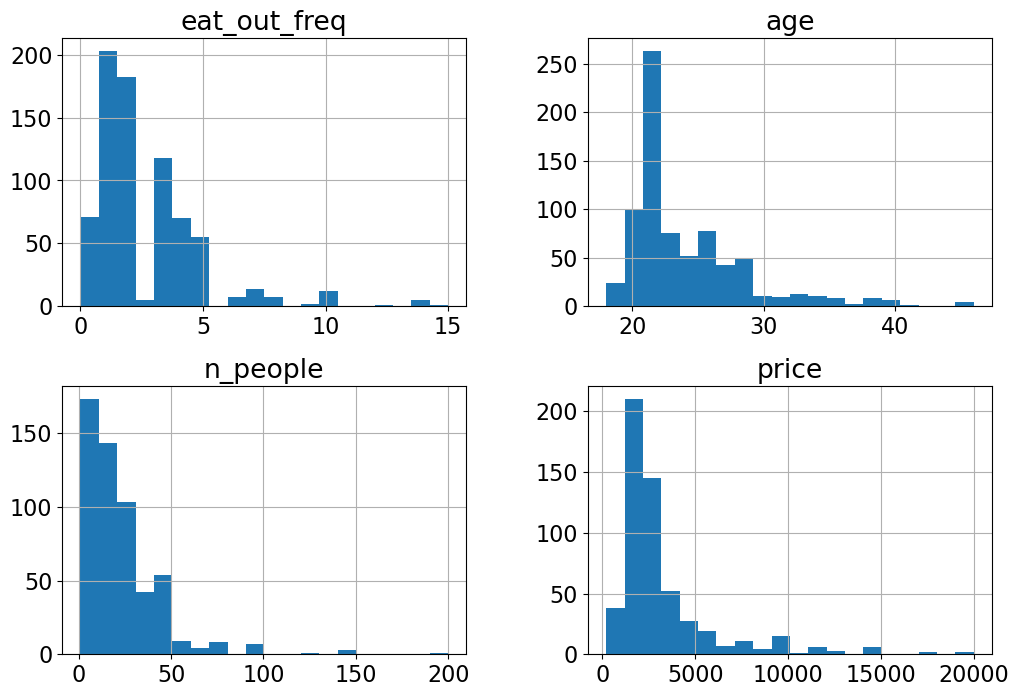

In [52]:
X_train.hist(bins=20, figsize=(12, 8));

Do you see anything interesting in these plots? 

In [53]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Thai                  20
Fusion                18
Mexican               17
fusion                 3
Quebecois              1
Name: count, dtype: int64

Error in data collection? Probably "Fusion" and "fusion" categories should be combined?

In [54]:
X_train['food_type'] = X_train['food_type'].replace("fusion", "Fusion")
X_test['food_type'] = X_test['food_type'].replace("fusion", "Fusion")

In [55]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Fusion                21
Thai                  20
Mexican               17
Quebecois              1
Name: count, dtype: int64

Again, usually we should spend lots of time in EDA, but let's stop here so that we have time to learn about transformers and pipelines.   

<br><br>

### Dummy Classifier

In [56]:
from sklearn.dummy import DummyClassifier

results_df = {}
dummy = DummyClassifier()
results_df['dummy'] = mean_std_cross_val_scores(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(results_df)

dummy
fit_time     0.001 (+/- 0.000)
score_time   0.001 (+/- 0.000)
test_score   0.515 (+/- 0.002)
train_score  0.515 (+/- 0.000)

We have a relatively balanced distribution of both 'like' and 'dislike' classes.

<br><br>

### Preprocessing

How can we horizontally stack  
- preprocessed numeric features, 
- preprocessed binary features, 
- preprocessed ordinal features, and 
- preprocessed categorical features?

Let's define a column transformer. 

In [57]:
numeric_feats = ['age', 'n_people', 'price'] # Continuous and quantitative features
categorical_feats = ['north_america', 'food_type'] # Discrete and qualitative features
binary_feats = ['good_server'] # Categorical features with only two possible values 
ordinal_feats = ['noise_level'] # Some natural ordering in the categories 
noise_cats = ['no music', 'low', 'medium', 'high', 'crazy loud']
drop_feats = ['comments', 'restaurant_name', 'eat_out_freq'] # Dropping text feats and `eat_out_freq` because it's not that useful

In [58]:
X_train['noise_level'].value_counts()

noise_level
medium        232
low           186
high           75
no music       37
crazy loud     18
Name: count, dtype: int64

In [59]:
noise_levels = ["no music", "low", "medium", "high", "crazy loud"]

In [60]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.compose import make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"),
                                    StandardScaler()) 
binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                    OneHotEncoder(drop="if_binary"))
ordinal_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                    OrdinalEncoder(categories=[noise_levels]))
categorical_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                    OneHotEncoder(sparse_output=False, handle_unknown="ignore"))

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_feats), 
    (binary_transformer, binary_feats), 
    (ordinal_transformer, ordinal_feats),
    (categorical_transformer, categorical_feats),
    ("drop", drop_feats)
)


How does the transformed data look like? 

In [61]:
transformed = preprocessor.fit_transform(X_train)
transformed.shape

(753, 17)

In [62]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'n_people', 'price']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['good_server']),
                                ('pipeline-3',...
                                                  OrdinalEncoder(categories=[['no '
                                                                              'music',
                                                                              'low',
                                                                              'medium',
                                                                              'high',
                                                                              'crazy '
                                                                              'loud']]))]),
                                 ['noise_level']),
                                ('pipeline-4',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['north_america', 'food_type']),
                                ('drop', 'drop',
                                 ['comments', 'restaurant_name',
                                  'eat_out_freq'])])

In [63]:
# Getting feature names from a column transformer
ohe_feat_names = preprocessor.named_transformers_['pipeline-4']['onehotencoder'].get_feature_names_out(categorical_feats).tolist()
ohe_feat_names

["north_america_Don't want to share",
 'north_america_No',
 'north_america_Yes',
 'food_type_Canadian/American',
 'food_type_Chinese',
 'food_type_Fusion',
 'food_type_Indian',
 'food_type_Italian',
 'food_type_Mexican',
 'food_type_Other',
 'food_type_Quebecois',
 'food_type_Thai']

In [64]:
numeric_feats

['age', 'n_people', 'price']

In [65]:
feat_names = numeric_feats + binary_feats + ordinal_feats + ohe_feat_names

In [66]:
transformed

array([[-0.66941678,  0.31029469, -0.36840629, ...,  0.        ,
         0.        ,  0.        ],
       [-0.66941678,  0.31029469, -0.05422496, ...,  0.        ,
         0.        ,  0.        ],
       [-0.89515383,  0.82336432, -0.25058829, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.89515383, -0.97237936, -0.64331495, ...,  0.        ,
         0.        ,  0.        ],
       [-0.89515383, -0.20277493, -0.25058829, ...,  1.        ,
         0.        ,  0.        ],
       [-0.89515383,  1.33643394, -0.05422496, ...,  0.        ,
         0.        ,  0.        ]])

In [67]:
pd.DataFrame(transformed, columns = feat_names)

age  n_people     price  good_server  noise_level  \
0   -0.669417  0.310295 -0.368406          0.0          3.0   
1   -0.669417  0.310295 -0.054225          1.0          1.0   
2   -0.895154  0.823364 -0.250588          1.0          2.0   
3   -0.669417 -0.202775 -0.250588          1.0          2.0   
4    0.007794 -0.202775 -0.054225          1.0          3.0   
..        ...       ...       ...          ...          ...   
748  0.685006 -0.715845 -0.643315          1.0          2.0   
749  0.007794 -0.613231 -0.918224          1.0          2.0   
750 -0.895154 -0.972379 -0.643315          0.0          1.0   
751 -0.895154 -0.202775 -0.250588          1.0          2.0   
752 -0.895154  1.336434 -0.054225          1.0          3.0   

     north_america_Don't want to share  north_america_No  north_america_Yes  \
0                                  0.0               1.0                0.0   
1                                  0.0               0.0                1.0   
2                                  0.0               1.0                0.0   
3                                  0.0               0.0                1.0   
4                                  0.0               0.0                1.0   
..                                 ...               ...                ...   
748                                0.0               1.0                0.0   
749                                0.0               1.0                0.0   
750                                0.0               0.0                1.0   
751                                0.0               0.0                1.0   
752                                1.0               0.0                0.0   

     food_type_Canadian/American  food_type_Chinese  food_type_Fusion  \
0                            0.0                1.0               0.0   
1                            1.0                0.0               0.0   
2                            1.0                0.0               0.0   
3                            0.0                0.0               0.0   
4                            0.0                0.0               0.0   
..                           ...                ...               ...   
748                          0.0                1.0               0.0   
749                          0.0                0.0               0.0   
750                          1.0                0.0               0.0   
751                          0.0                0.0               0.0   
752                          0.0                1.0               0.0   

     food_type_Indian  food_type_Italian  food_type_Mexican  food_type_Other  \
0                 0.0                0.0                0.0              0.0   
1                 0.0                0.0                0.0              0.0   
2                 0.0                0.0                0.0              0.0   
3                 0.0                0.0                0.0              0.0   
4                 1.0                0.0                0.0              0.0   
..                ...                ...                ...              ...   
748               0.0                0.0                0.0              0.0   
749               0.0                0.0                0.0              1.0   
750               0.0                0.0                0.0              0.0   
751               0.0                0.0                0.0              1.0   
752               0.0                0.0                0.0              0.0   

     food_type_Quebecois  food_type_Thai  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    1.0             0.0  
4                    0.0             0.0  
..                   ...             ...  
748                  0.0             0.0  
749                  0.0             0.0  
750                  0.0             0.0  
751                  0.0            

We have new columns for the categorical features. Let's create a pipeline with the preprocessor and SVC. 

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()    
}

for (name, model) in models.items():
    pipe_num_model = make_pipeline(SimpleImputer(strategy="median"), StandardScaler(), model)
    results_df[name +' (numeric-only)'] = mean_std_cross_val_scores(pipe_num_model, X_train[numeric_feats], y_train, return_train_score=True)
pd.DataFrame(results_df).T

fit_time         score_time  \
dummy                         0.001 (+/- 0.000)  0.001 (+/- 0.000)   
Decision Tree (numeric-only)  0.003 (+/- 0.000)  0.001 (+/- 0.000)   
KNN (numeric-only)            0.003 (+/- 0.001)  0.004 (+/- 0.000)   
SVM (numeric-only)            0.012 (+/- 0.000)  0.005 (+/- 0.000)   

                                     test_score        train_score  
dummy                         0.515 (+/- 0.002)  0.515 (+/- 0.000)  
Decision Tree (numeric-only)  0.497 (+/- 0.038)  0.833 (+/- 0.010)  
KNN (numeric-only)            0.525 (+/- 0.034)  0.674 (+/- 0.015)  
SVM (numeric-only)            0.587 (+/- 0.033)  0.623 (+/- 0.006)

In [69]:
for (name, model) in models.items():
    pipe_model = make_pipeline(preprocessor, model)
    results_df[name + '(non-text feats)'] = mean_std_cross_val_scores(pipe_model, X_train, y_train, return_train_score=True)
pd.DataFrame(results_df).T

fit_time         score_time  \
dummy                          0.001 (+/- 0.000)  0.001 (+/- 0.000)   
Decision Tree (numeric-only)   0.003 (+/- 0.000)  0.001 (+/- 0.000)   
KNN (numeric-only)             0.003 (+/- 0.001)  0.004 (+/- 0.000)   
SVM (numeric-only)             0.012 (+/- 0.000)  0.005 (+/- 0.000)   
Decision Tree(non-text feats)  0.009 (+/- 0.000)  0.003 (+/- 0.000)   
KNN(non-text feats)            0.008 (+/- 0.000)  0.004 (+/- 0.000)   
SVM(non-text feats)            0.019 (+/- 0.000)  0.008 (+/- 0.000)   

                                      test_score        train_score  
dummy                          0.515 (+/- 0.002)  0.515 (+/- 0.000)  
Decision Tree (numeric-only)   0.497 (+/- 0.038)  0.833 (+/- 0.010)  
KNN (numeric-only)             0.525 (+/- 0.034)  0.674 (+/- 0.015)  
SVM (numeric-only)             0.587 (+/- 0.033)  0.623 (+/- 0.006)  
Decision Tree(non-text feats)  0.590 (+/- 0.039)  0.889 (+/- 0.008)  
KNN(non-text feats)            0.598 (+/- 0.023)  0.737 (+/- 0.008)  
SVM(non-text feats)            0.687 (+/- 0.011)  0.733 (+/- 0.008)

We are getting better results when we include numeric, categorical, binary, ordinal features. 
<br><br><br>

### Incorporating text features 

We haven't incorporated the comments feature into our pipeline yet, even though it holds significant value in indicating whether the restaurant was liked or not.

In [70]:
X_train

north_america  eat_out_freq  age  n_people   price  \
80                    No           2.0   21      30.0  2200.0   
934                  Yes           4.0   21      30.0  3000.0   
911                   No           4.0   20      40.0  2500.0   
459                  Yes           5.0   21       NaN     NaN   
62                   Yes           2.0   24      20.0  3000.0   
..                   ...           ...  ...       ...     ...   
106                   No           3.0   27      10.0  1500.0   
333                   No           1.0   24      12.0   800.0   
393                  Yes           4.0   20       5.0  1500.0   
376                  Yes           5.0   20       NaN     NaN   
525  Don't want to share           4.0   20      50.0  3000.0   

             food_type noise_level good_server  \
80             Chinese        high          No   
934  Canadian/American         low         Yes   
911  Canadian/American      medium         Yes   
459          Quebecois         NaN         NaN   
62              Indian        high         Yes   
..                 ...         ...         ...   
106            Chinese      medium         Yes   
333              Other      medium         Yes   
393  Canadian/American         low          No   
376                NaN         NaN         NaN   
525            Chinese        high         Yes   

                                                                                                                    comments  \
80                                                                The environment was very not clean. The food tasted awful.   
934  The building and the room gave a very comfy feeling. Immediately after sitting down it felt like we were right at home.   
911                                                                                                             I was hungry   
459                                                                                                                      NaN   
62                                                                                                                 bad taste   
..                                                                                                                       ...   
106                                                                                                      Food wasn't great.    
333                                                                                                                      NaN   
393                                                                                                                      NaN   
376                                                                                                                      NaN   
525                                                                                                                      NaN   

    restaurant_name  
80              NaN  
934             NaN  
911         Chambar  
459             NaN  
62     east is east  
..              ...  
106             NaN  
333             NaN  
393             NaN  
376             NaN  
525        Haidilao  

[753 rows x 10 columns]

Let's create bag-of-words representation of the `comments` feature. But first we need to impute the rows where there are no comments. There is a small complication if we want to put `SimpleImputer` and `CountVectorizer` in a pipeline. 
- `SimpleImputer` takes a 2D array as input and produced 2D array as output. 
- `CountVectorizer` takes a 1D array as input. 

To deal with this, we will use sklearn's `FunctionTransformer` to convert the 2D output of `SimpleImputer` into a 1D array which can be passed to `CountVectorizer` as input. 

In [71]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

reshape_for_countvectorizer = FunctionTransformer(lambda X: X.squeeze(), validate=False)
text_transformer = make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"), 
                          reshape_for_countvectorizer, 
                          CountVectorizer(stop_words="english"))
text_pipe = make_pipeline(text_transformer, SVC())
cross_val_score(text_pipe, X_train[['comments']], y_train).mean()

0.6493951434878588

Pretty good scores just with text features! Let's examine the transformed data. 

In [72]:
transformed = text_transformer.fit_transform(X_train[['comments']], y_train)

In [73]:
transformed

<753x548 sparse matrix of type '<class 'numpy.int64'>'
	with 1841 stored elements in Compressed Sparse Row format>

It's a sparse matrix. Let's explore the the vocabulary. 

In [74]:
vocab = text_transformer.named_steps["countvectorizer"].get_feature_names_out()
vocab[:10]

array(['18', '30', '40mins', '65', 'actually', 'addition', 'affordable',
       'alcohol', 'ale', 'allergic'], dtype=object)

In [75]:
vocab[0:10]

array(['18', '30', '40mins', '65', 'actually', 'addition', 'affordable',
       'alcohol', 'ale', 'allergic'], dtype=object)

In [76]:
vocab[200:210]

array(['fusion', 'games', 'gave', 'general', 'genuinely', 'getting',
       'ginger', 'girlfriends', 'gluten', 'going'], dtype=object)

In [77]:
vocab[500:600]

array(['undressed', 'unfresh', 'uni', 'unique', 'unreasonable', 'upset',
       'usual', 'uwu', 'value', 'vancouver', 'variety', 'vds', 've',
       'vegan', 'vibe', 'vibes', 'vietnamese', 'view', 'visit', 'wait',
       'waited', 'waiter', 'waiters', 'waiting', 'waitress', 'walking',
       'want', 'warm', 'washrooms', 'wasn', 'water', 'watery', 'way',
       'weekend', 'went', 'wet', 'wife', 'wind', 'window', 'wine',
       'wings', 'winter', 'work', 'worst', 'wrong', 'yelling', 'yield',
       'yummy'], dtype=object)

In [78]:
vocab[0::20]

array(['18', 'ask', 'better', 'cash', 'closing', 'country', 'dessert',
       'drunk', 'expecting', 'figuring', 'fusion', 'having', 'impeccable',
       'knowledgeable', 'love', 'nice', 'pain', 'played', 'quality',
       'removed', 'sauces', 'sitting', 'spoke', 'tacky', 'time',
       'undressed', 'waited', 'wings'], dtype=object)

<br><br>

 Do we get better scores if we combine all features? Let's define a column transformer which carries out 
- imputation and scaling on numeric features
- imputation and one-hot encoding with `drop="if_binary"` on binary features
- imputation and one-hot encoding with `handle_unknown="ignore"` on categorical features
- imputation, reshaping, and bag-of-words transformation on the text feature

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
text_feat = ['comments']

preprocessor_all = make_column_transformer(
    (numeric_transformer, numeric_feats), 
    (binary_transformer, binary_feats), 
    (ordinal_transformer, ordinal_feats),
    (categorical_transformer, categorical_feats),
    (text_transformer, text_feat), 
    ("drop", drop_feats)
)

In [80]:
preprocessor_all.fit_transform(X_train)

<753x565 sparse matrix of type '<class 'numpy.float64'>'
	with 6927 stored elements in Compressed Sparse Row format>

In [81]:
for (name, model) in models.items():
    pipe_model = make_pipeline(text_transformer, model)
    results_df[name + '(text)'] = mean_std_cross_val_scores(pipe_model, X_train[['comments']], y_train, return_train_score=True)
pd.DataFrame(results_df).T

fit_time         score_time  \
dummy                          0.001 (+/- 0.000)  0.001 (+/- 0.000)   
Decision Tree (numeric-only)   0.003 (+/- 0.000)  0.001 (+/- 0.000)   
KNN (numeric-only)             0.003 (+/- 0.001)  0.004 (+/- 0.000)   
SVM (numeric-only)             0.012 (+/- 0.000)  0.005 (+/- 0.000)   
Decision Tree(non-text feats)  0.009 (+/- 0.000)  0.003 (+/- 0.000)   
KNN(non-text feats)            0.008 (+/- 0.000)  0.004 (+/- 0.000)   
SVM(non-text feats)            0.019 (+/- 0.000)  0.008 (+/- 0.000)   
Decision Tree(text)            0.008 (+/- 0.001)  0.001 (+/- 0.000)   
KNN(text)                      0.004 (+/- 0.000)  0.006 (+/- 0.002)   
SVM(text)                      0.010 (+/- 0.000)  0.003 (+/- 0.000)   

                                      test_score        train_score  
dummy                          0.515 (+/- 0.002)  0.515 (+/- 0.000)  
Decision Tree (numeric-only)   0.497 (+/- 0.038)  0.833 (+/- 0.010)  
KNN (numeric-only)             0.525 (+/- 0.034)  0.674 (+/- 0.015)  
SVM (numeric-only)             0.587 (+/- 0.033)  0.623 (+/- 0.006)  
Decision Tree(non-text feats)  0.590 (+/- 0.039)  0.889 (+/- 0.008)  
KNN(non-text feats)            0.598 (+/- 0.023)  0.737 (+/- 0.008)  
SVM(non-text feats)            0.687 (+/- 0.011)  0.733 (+/- 0.008)  
Decision Tree(text)            0.618 (+/- 0.036)  0.735 (+/- 0.004)  
KNN(text)                      0.572 (+/- 0.023)  0.646 (+/- 0.026)  
SVM(text)                      0.649 (+/- 0.022)  0.728 (+/- 0.005)

In [82]:
for (name, model) in models.items():
    pipe_model = make_pipeline(preprocessor_all, model)
    results_df[name + '(all)'] = mean_std_cross_val_scores(pipe_model, X_train, y_train, return_train_score=True)
pd.DataFrame(results_df).T

fit_time         score_time  \
dummy                          0.001 (+/- 0.000)  0.001 (+/- 0.000)   
Decision Tree (numeric-only)   0.003 (+/- 0.000)  0.001 (+/- 0.000)   
KNN (numeric-only)             0.003 (+/- 0.001)  0.004 (+/- 0.000)   
SVM (numeric-only)             0.012 (+/- 0.000)  0.005 (+/- 0.000)   
Decision Tree(non-text feats)  0.009 (+/- 0.000)  0.003 (+/- 0.000)   
KNN(non-text feats)            0.008 (+/- 0.000)  0.004 (+/- 0.000)   
SVM(non-text feats)            0.019 (+/- 0.000)  0.008 (+/- 0.000)   
Decision Tree(text)            0.008 (+/- 0.001)  0.001 (+/- 0.000)   
KNN(text)                      0.004 (+/- 0.000)  0.006 (+/- 0.002)   
SVM(text)                      0.010 (+/- 0.000)  0.003 (+/- 0.000)   
Decision Tree(all)             0.016 (+/- 0.001)  0.005 (+/- 0.001)   
KNN(all)                       0.013 (+/- 0.000)  0.012 (+/- 0.001)   
SVM(all)                       0.023 (+/- 0.000)  0.008 (+/- 0.001)   

                                      test_score        train_score  
dummy                          0.515 (+/- 0.002)  0.515 (+/- 0.000)  
Decision Tree (numeric-only)   0.497 (+/- 0.038)  0.833 (+/- 0.010)  
KNN (numeric-only)             0.525 (+/- 0.034)  0.674 (+/- 0.015)  
SVM (numeric-only)             0.587 (+/- 0.033)  0.623 (+/- 0.006)  
Decision Tree(non-text feats)  0.590 (+/- 0.039)  0.889 (+/- 0.008)  
KNN(non-text feats)            0.598 (+/- 0.023)  0.737 (+/- 0.008)  
SVM(non-text feats)            0.687 (+/- 0.011)  0.733 (+/- 0.008)  
Decision Tree(text)            0.618 (+/- 0.036)  0.735 (+/- 0.004)  
KNN(text)                      0.572 (+/- 0.023)  0.646 (+/- 0.026)  
SVM(text)                      0.649 (+/- 0.022)  0.728 (+/- 0.005)  
Decision Tree(all)             0.624 (+/- 0.022)  0.893 (+/- 0.006)  
KNN(all)                       0.625 (+/- 0.027)  0.748 (+/- 0.015)  
SVM(all)                       0.699 (+/- 0.017)  0.786 (+/- 0.008)

Some improvement when we combine all features! 